<a href="https://colab.research.google.com/github/ztjfreedom/colab/blob/master/keras_lstm_glove_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install numpy==1.16.2

     |████████████████████████████████| 17.3MB 3.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4


In [24]:
import os
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Flatten, Bidirectional, BatchNormalization
from keras.layers import LSTM, CuDNNLSTM

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import matplotlib.pyplot as plt
import h5py

print(np.__version__)

1.16.2


In [0]:
# number of most-frequent words to use
words_num = 10000
# cut texts after this number of words
max_len = 80

In [28]:
print('Loading data...')

pad_id = 0
start_id = 1
oov_id = 2
index_offset = 2
 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=words_num, start_char=start_id,
                                                      oov_char=oov_id, index_from=index_offset)
 
word2idx = imdb.get_word_index()

print('word2idx[the]:', word2idx['the'])
print('x_train[0]:', x_train[0])

Loading data...
word2idx[the]: 1
x_train[0]: [1, 13, 21, 15, 42, 529, 972, 1621, 1384, 64, 457, 4467, 65, 3940, 3, 172, 35, 255, 4, 24, 99, 42, 837, 111, 49, 669, 2, 8, 34, 479, 283, 4, 149, 3, 171, 111, 166, 2, 335, 384, 38, 3, 171, 4535, 1110, 16, 545, 37, 12, 446, 3, 191, 49, 15, 5, 146, 2024, 18, 13, 21, 3, 1919, 4612, 468, 3, 21, 70, 86, 11, 15, 42, 529, 37, 75, 14, 12, 1246, 3, 21, 16, 514, 16, 11, 15, 625, 17, 2, 4, 61, 385, 11, 7, 315, 7, 105, 4, 3, 2222, 5243, 15, 479, 65, 3784, 32, 3, 129, 11, 15, 37, 618, 4, 24, 123, 50, 35, 134, 47, 24, 1414, 32, 5, 21, 11, 214, 27, 76, 51, 4, 13, 406, 15, 81, 2, 7, 3, 106, 116, 5951, 14, 255, 3, 2, 6, 3765, 4, 722, 35, 70, 42, 529, 475, 25, 399, 316, 45, 6, 3, 2, 1028, 12, 103, 87, 3, 380, 14, 296, 97, 31, 2070, 55, 25, 140, 5, 193, 7485, 17, 3, 225, 21, 20, 133, 475, 25, 479, 4, 143, 29, 5534, 17, 50, 35, 27, 223, 91, 24, 103, 3, 225, 64, 15, 37, 1333, 87, 11, 15, 282, 4, 15, 4471, 112, 102, 31, 14, 15, 5344, 18, 177, 31]


In [33]:
word2idx = {k: v + index_offset for k, v in word2idx.items()}
idx2word = {v: k for k, v in word2idx.items()}
 
idx2word[pad_id] = '<PAD>'
idx2word[start_id] = '<START>'
idx2word[oov_id] = '<OOV>'

x_train = pad_sequences(x_train, maxlen=max_len, truncating='post', padding='post', value=pad_id)
x_test = pad_sequences(x_test, maxlen=max_len, truncating='post', padding='post', value=pad_id)

print('Review at word2idx:')
print('word the:', word2idx['the'])

print('Review at idx2word:')
print('idx 0:', idx2word[0])
print('idx 1:', idx2word[1])
print('idx 2:', idx2word[2])
print('idx 3:', idx2word[3])

Review at word2idx:
word the: 3
Review at idx2word:
idx 0: <PAD>
idx 1: <START>
idx 2: <OOV>
idx 3: the


In [34]:
decoded_review = ' '.join([idx2word[i] for i in x_train[0]])
print(decoded_review)

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <OOV> is an amazing actor and now the same being director <OOV> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as


In [35]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Colab Notebooks/dataset/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/My Drive/Colab Notebooks/dataset/'
/content/gdrive/My Drive/Colab Notebooks/dataset


In [36]:
# Parsing GLoVE word embedding files
glove_dict = {}
with open(os.path.join('glove', 'glove.6B.50d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_dict[word] = coefs


print('Found %s word vectors.' % len(glove_dict))

for key in glove_dict.keys():
    print('Frist key:', key)
    break

Found 400000 word vectors.
Frist key: the


In [37]:
# 0 is used for padding, so we set it to all zeros
embedding_matrix = np.random.normal(loc=0.0, scale=1.0, size=(10000, 50))
embedding_matrix[0] = np.zeros(50)
for word, i in word2idx.items():
    if i < 10000:
        embedding_vector = glove_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print('Embedding review:')
print(embedding_matrix.shape)
print(embedding_matrix[0])
print(embedding_matrix[1])
print(embedding_matrix[3])
print(glove_dict['the'])

Embedding review:
(10000, 50)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[ 1.42576577 -1.74478284 -0.64736253  0.26380198 -0.46950615  0.04085707
 -1.00885976  1.45821201 -1.06941491 -1.02752209 -0.63001538 -1.55715559
 -0.58781136 -0.16534477 -0.22280624 -0.92582924  0.63208453  0.67441906
  1.1971006   1.90387458 -1.94896777 -0.8279956   1.06974494 -0.55934359
  1.18077087  0.17849756  1.36668251  0.14156975 -0.66128088  1.30115542
 -1.43224451  1.35921625 -0.66289783  0.28906809 -0.80765559 -0.1648786
 -0.18261234 -0.36393716  1.21956617  0.52869823  2.4136912  -0.45797747
  0.11586065 -0.55238252  0.47984307  0.65838836 -0.23103201 -1.21848454
  1.27952061 -0.39359994]
[ 4.18000013e-01  2.49679998e-01 -4.12420005e-01  1.21699996e-01
  3.45270008e-01 -4.44569997e-02 -4.96879995e-01 -1.78619996e-01
 -6.60229998e-04 -6.56599998e-01  2.78430015e-01 -1.47670001e-01
 -5.56770027

### Freeze all pre-trained embeddings

In [38]:
# model parameters:
embedding_dims = 50
lstm_units = 128

print('Build model...')
model = Sequential()

model.add(Embedding(words_num,
                    embedding_dims,
                    input_length=max_len))

model.add(Dropout(rate=0.5))

# Bidirectional 2 layers LSTM
# CPU ver:
#model.add(LSTM(lstm_units))
# GPU ver:
model.add(Bidirectional(CuDNNLSTM(lstm_units, return_sequences=True)))

model.add(BatchNormalization())

model.add(Dropout(rate=0.5))

model.add(Bidirectional(CuDNNLSTM(lstm_units)))

model.add(Dense(1, activation='sigmoid'))

# Load pretrained word embeddings into the Embedding layer
# Freeze the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 50)            500000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 80, 50)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 80, 256)           184320    
_________________________________________________________________
batch_normalization_2 (Batch (None, 80, 256)           1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 80, 256)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               395264    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257   

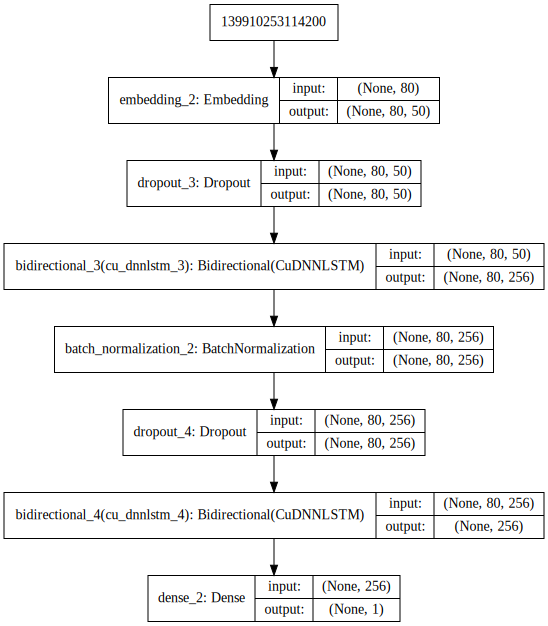

In [39]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [40]:
%%time
epochs = 20
validation_split = 0.2

history = model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 7s 371us/step - loss: 0.6377 - acc: 0.6333 - val_loss: 0.6199 - val_acc: 0.6810
Epoch 2/20
20000/20000 [==============================] - 6s 294us/step - loss: 0.5919 - acc: 0.6830 - val_loss: 0.5619 - val_acc: 0.7140
Epoch 3/20
20000/20000 [==============================] - 6s 302us/step - loss: 0.5690 - acc: 0.7025 - val_loss: 0.5875 - val_acc: 0.7062
Epoch 4/20
20000/20000 [==============================] - 6s 290us/step - loss: 0.5594 - acc: 0.7102 - val_loss: 0.6039 - val_acc: 0.6962
Epoch 5/20
20000/20000 [==============================] - 6s 304us/step - loss: 0.5413 - acc: 0.7247 - val_loss: 0.5080 - val_acc: 0.7448
Epoch 6/20
20000/20000 [==============================] - 6s 297us/step - loss: 0.5264 - acc: 0.7326 - val_loss: 0.5462 - val_acc: 0.7406
Epoch 7/20
20000/20000 [==============================] - 6s 299us/step - loss: 0.5211 - acc: 0.7373 - val_loss: 0.5482 - v

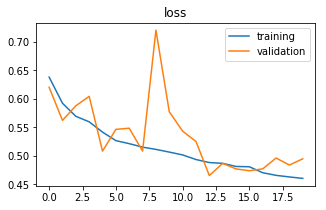

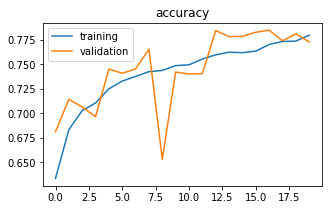

In [41]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'], label='training')
plt.plot(history.epoch,history.history['val_acc'], label='validation')
plt.title('accuracy')
plt.legend(loc='best');

In [42]:
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 75.67%


### Do not freeze pre-trained embeddings

In [43]:
# model parameters:
embedding_dims = 50
lstm_units = 128

print('Build model...')
model = Sequential()

model.add(Embedding(words_num,
                      embedding_dims,
                      input_length=max_len))

model.add(Dropout(rate=0.7))

# Bidirectional 2 layers LSTM
# CPU ver:
#model.add(LSTM(lstm_units))
# GPU ver:
model.add(Bidirectional(CuDNNLSTM(lstm_units, return_sequences=True)))

model.add(BatchNormalization())

model.add(Dropout(rate=0.7))

model.add(Bidirectional(CuDNNLSTM(lstm_units)))

model.add(Dense(1, activation='sigmoid'))

# Load pretrained word embeddings into the Embedding layer
# Only free the embedding of pad token
model.layers[0].set_weights([embedding_matrix])

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
print(model.summary())

W0629 05:34:00.918904 139911780980608 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Build model...


W0629 05:34:01.244583 139911780980608 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 80, 50)            500000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 80, 50)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 80, 256)           184320    
_________________________________________________________________
batch_normalization_3 (Batch (None, 80, 256)           1024      
_________________________________________________________________
dropout_6 (Dropout)          (None, 80, 256)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 256)               395264    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total para

In [44]:
%%time
epochs = 20
validation_split = 0.2

history = model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 8s 393us/step - loss: 0.6555 - acc: 0.6139 - val_loss: 0.6938 - val_acc: 0.6540
Epoch 2/20
20000/20000 [==============================] - 6s 308us/step - loss: 0.5957 - acc: 0.6830 - val_loss: 0.6200 - val_acc: 0.7260
Epoch 3/20
20000/20000 [==============================] - 6s 302us/step - loss: 0.5495 - acc: 0.7205 - val_loss: 0.5622 - val_acc: 0.7670
Epoch 4/20
20000/20000 [==============================] - 6s 308us/step - loss: 0.5196 - acc: 0.7388 - val_loss: 0.7244 - val_acc: 0.7052
Epoch 5/20
20000/20000 [==============================] - 6s 308us/step - loss: 0.4933 - acc: 0.7573 - val_loss: 0.5797 - val_acc: 0.7350
Epoch 6/20
20000/20000 [==============================] - 6s 305us/step - loss: 0.4712 - acc: 0.7736 - val_loss: 0.4295 - val_acc: 0.8076
Epoch 7/20
20000/20000 [==============================] - 6s 308us/step - loss: 0.4584 - acc: 0.7782 - val_loss: 0.4801 - v

In [45]:
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 81.62%
